# Ikeda eddy damping

# Purpose
Investigate the implementation of the eddy damping 

# Methodology
Following the sectional eddy damping published in <cite data-cite="7505983/4AFVVGNT"></cite>.

![](ikeda_eddy_section_A.PNG)
<div class="cite2c-biblio"></div>

In [21]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables
import shipflowmotionshelpers.shipflowmotionshelpers as helpers


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from rolldecayestimators import ikeda_speed
from rolldecayestimators import simplified_ikeda
import seaborn as sns

In [23]:
df = pd.read_csv('../data/external/ikeda_eddy._sections.csv', sep=';', index_col=0)
df.head()

,L,B,d,volume,H0,sigma,OG/d,R
No,,,,,,,,
A,0.8,0.280,0.112,0.02509,1.250,1.000,0.000,0.00
B,0.8,0.280,0.112,0.02501,1.250,0.997,0.000,0.01
C,0.8,0.280,0.112,0.02495,1.250,0.995,0.000,0.02
D,0.8,0.280,0.112,0.02475,1.250,0.988,0.000,0.03
E,0.8,0.024,0.070,0.00116,0.171,0.866,-1.753,NaN


# Model A

In [24]:
parameters = df.loc['A']

In [25]:
sigma = parameters.sigma
B_s = np.array([parameters.B])
T_s = parameters.d
S_s = sigma*B_s*T_s
a, a_1, a_3, sigma_s, H = ikeda_speed.calculate_sectional_lewis(B_s=B_s, T_s=T_s, S_s=S_s)

In [26]:
OG=parameters['OG/d']*parameters.d
R = parameters.R 

g = 9.81
rho = 1000

fi_a = 0.175
w_hats = np.linspace(0,1.0,10)

w = lambdas.omega_from_hat(beam=parameters.B, g=g, omega_hat=w_hats)
B_E0_s = ikeda_speed.eddy_sections(bwl=B_s, a_1=a_1, a_3=a_3, sigma=sigma_s, H0=H, Ts=T_s,
         OG=OG, R=R, wE=w, fi_a=fi_a, ra=1000.0)
B_E0 = B_E0_s*parameters.L

Disp = parameters.volume
B_E0_hat = lambdas.B_to_hat_lambda(B=B_E0, Disp=Disp, beam=B_s, g=g, rho=rho)
B_E0_star_hat = B_E0_hat*3*np.pi/8


Text(0, 0.5, '$\\hat{B_E}*$')

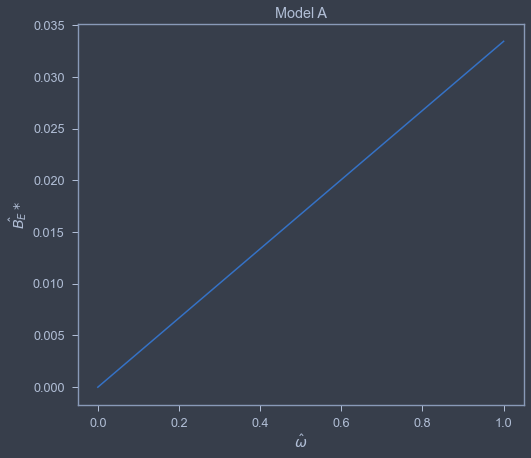

In [27]:
fig,ax=plt.subplots()
ax.plot(w_hats, B_E0_star_hat[0])
ax.set_title('Model A')
ax.set_xlabel(r'$\hat{\omega}$')
ax.set_ylabel(r'$\hat{B_E}*$')

In [28]:
def calculate_lewis(parameters):
    sigma = parameters.sigma
    B_s = np.array([parameters.B])
    T_s = parameters.d
    S_s = sigma*B_s*T_s
    return ikeda_speed.calculate_sectional_lewis(B_s=B_s, T_s=T_s, S_s=S_s)

def calculate_B_star_hat(parameters, fi_a, w_hat, g=9.81, rho=1000, **kwargs):
    
    a, a_1, a_3, sigma_s, H = calculate_lewis(parameters=parameters)
    
    OG=parameters['OG/d']*parameters.d
    R = parameters.R 
        
    w = lambdas.omega_from_hat(beam=parameters.B, g=g, omega_hat=w_hat)
    B_E0_s = ikeda_speed.eddy_sections(bwl=B_s, a_1=a_1, a_3=a_3, sigma=sigma_s, H0=H, Ts=T_s,
             OG=OG, R=R, wE=w, fi_a=fi_a, ra=1000.0)
    B_E0 = B_E0_s*parameters.L
    
    Disp = parameters.volume
    B_E0_hat = lambdas.B_to_hat_lambda(B=B_E0, Disp=Disp, beam=B_s, g=g, rho=rho)
    B_E0_star_hat = B_E0_hat*3*np.pi/8
    
    return B_E0_star_hat

In [29]:
def variation(parameters, df_variations):
    
    data = np.tile(parameters,(len(df_variations),1))
    df = pd.DataFrame(data, columns=parameters.index)
    df = pd.concat((df,df_variations),axis=1)
    return df

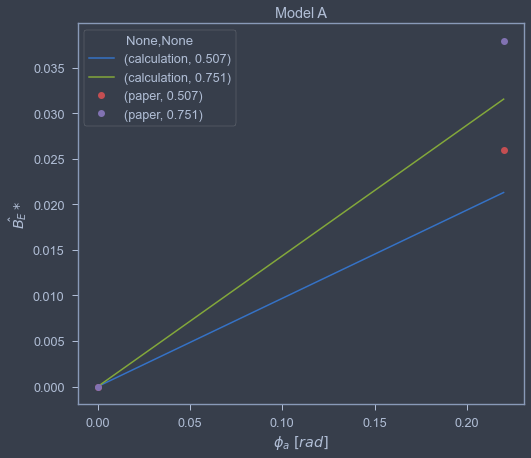

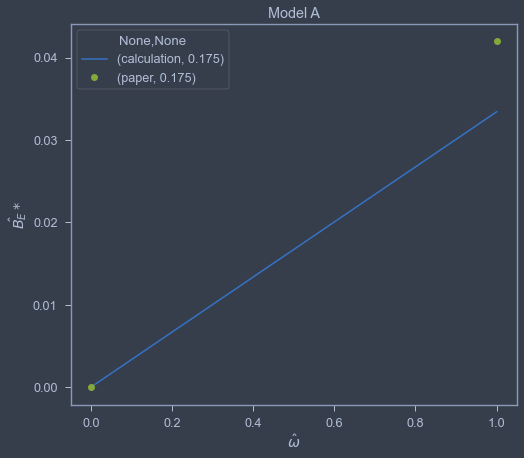

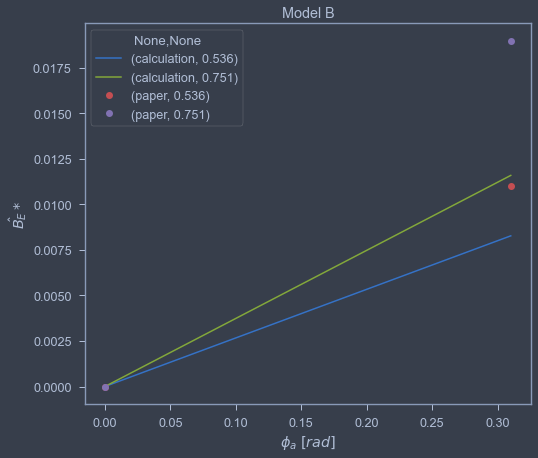

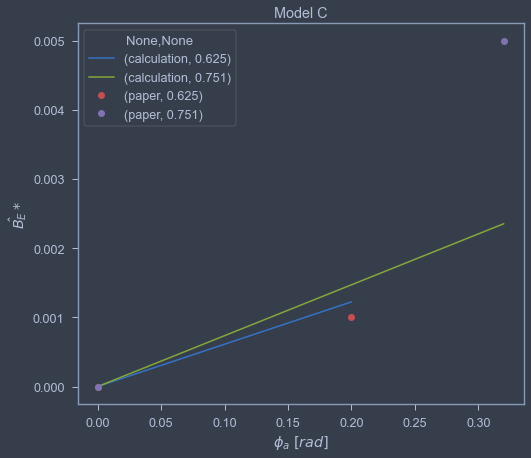

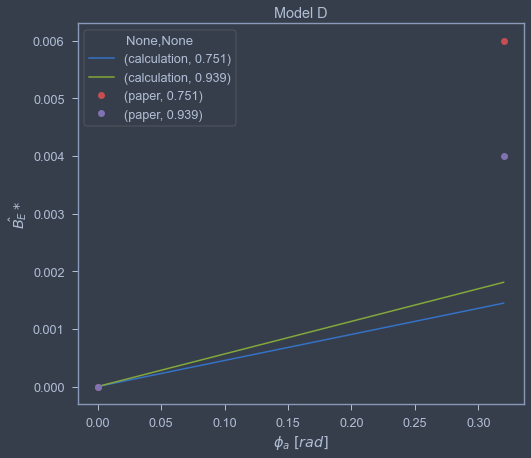

In [30]:
variations = {
    'A':
        [
            {
                'fi_a':0.175,
                'w_hat': (0,1.0),
                'paper':[0,0.042],  ## From the paper
            },
            {
                'fi_a':(0, 0.22),
                'w_hat':0.507,
                'paper':[0,0.026],  ## From the paper
            },
            {
                'fi_a':(0, 0.22),
                'w_hat':0.751,
                'paper':[0,0.038],  ## From the paper
            },
        ],
    
    'B':
        [
            {
                'fi_a':(0, 0.31),
                'w_hat':0.536,
                'paper':[0,0.011],  ## From the paper
            },
            {
                'fi_a':(0, 0.31),
                'w_hat':0.751,
                'paper':[0,0.019],  ## From the paper
            },
        ],
    'C':
        [
            {
                'fi_a':(0, 0.2),
                'w_hat':0.625,
                'paper':[0,0.001],  ## From the paper
            },
            {
                'fi_a':(0, 0.32),
                'w_hat':0.751,
                'paper':[0,0.005],  ## From the paper
            },
        ],
    'D':
        [
            {
                'fi_a':(0, 0.32),
                'w_hat':0.751,
                'paper':[0,0.006],  ## From the paper
            },
            {
                'fi_a':(0, 0.32),
                'w_hat':0.939,
                'paper':[0,0.004],  ## From the paper
            },
        ]   

}

N = 10
df_variations = pd.DataFrame()
for model_name, items in variations.items():
    df_variations_model = pd.DataFrame()

    model=model_name
    for item in items:
        variation = pd.DataFrame(index=np.arange(N))
        for key,value in item.items():
            
            if key=='paper':
                continue
            
            if isinstance(value,tuple):
                values = np.linspace(*value,N)
                variation['variate']=key
            else:
                values = value
            
            variation[key]=values
        
        variation['model']=model
        df_variations_model = df_variations_model.append(variation, ignore_index=True)
        
        
    parameters = df.loc[model_name]
    df_variations_model['B_E0_star_hat'] = calculate_B_star_hat(parameters=parameters,
                                                                **df_variations_model)[0]
    df_variations = df_variations.append(df_variations_model, ignore_index=True)

df_variations['source']='calculation'
df_variations['style'] = '-'

## Paper data
for model_name, items in variations.items():
    model=model_name
    for item in items:
        if 'paper' in item:
            
            data = {
                'fi_a':[np.min(item['fi_a']), np.max(item['fi_a'])],
                'w_hat':[np.min(item['w_hat']), np.max(item['w_hat'])],
                'B_E0_star_hat':item['paper'],
            }
            df_data = pd.DataFrame(data=data)
            df_data['model'] = model
            df_data['source'] = 'paper'
            df_data['style'] = '.'
            for key,value in item.items():
            
                if key=='paper':
                    continue
                if isinstance(value,tuple):
                    df_data['variate']=key
            
        df_variations = df_variations.append(df_data, ignore_index=True)
    
## Plotting
for model_name, model_data in df_variations.groupby(by='model'):
    
    fig,ax=plt.subplots()
    mask = model_data['variate']=='fi_a'
    data = model_data.loc[mask]
    for source,df_ in data.groupby(by=['source','w_hat']):
        if 'paper' in source:
            style='o'
        else:
            style='-'
        df_.plot(x="fi_a", y="B_E0_star_hat", ax=ax, style=style, label=source);
        
    
    title = 'Model %s' % model_name
    ax.set_title(title)
    ax.set_xlabel(r'$\phi_a$ $[rad]$')
    ax.set_ylabel(r'$\hat{B_E}*$')
    
    
    mask = model_data['variate']=='w_hat'
    data = model_data.loc[mask]
    if len(data)>0:
        fig,ax=plt.subplots()
        for source,df_ in data.groupby(by=['source','fi_a']):
            if 'paper' in source:
                style='o'
            else:
                style='-'
            df_.plot(x="w_hat", y="B_E0_star_hat", ax=ax, style=style, label=source);
        
        ax.set_title(title)
        ax.set_xlabel(r'$\hat{\omega}$')
        ax.set_ylabel(r'$\hat{B_E}*$')